In [1]:
import pandas as pd
import numpy as np
import random
import scipy.optimize as scopt

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [2]:
from supplement_package.game.gradient import GradientComputation
from supplement_package.game.player import Player
from supplement_package.game.stackelberg import StackelbergPlayer
from supplement_package.game.stackelberg import StackelbergGradientComputation

In [3]:
StackelbergGradientComputation.__dict__

mappingproxy({'__module__': 'supplement_package.game.stackelberg',
              '__init__': <function supplement_package.game.stackelberg.StackelbergGradientComputation.__init__(self) -> None>,
              'risk_utility_grad': <staticmethod at 0x1334e87f0>,
              'stackelberg_penalty_residual': <staticmethod at 0x1334e8820>,
              'penalty_jmin': <staticmethod at 0x1334e8850>,
              'penalty_jmax': <staticmethod at 0x1334e8880>,
              'penalty_risk_balance': <staticmethod at 0x1334e88b0>,
              '__doc__': None})

In [4]:
community_size = 3

In [5]:
if community_size == 3:
    D_min = [0.0,0.0,0.0]
    D_max = [10.0,10.0,10.0]

    G_min = [0.0,0.0,0.0]
    G_max = [10.0,0.0,0.0]
    
    Kappa = [[0.0, 10.0, 10.0],
             [10.0, 0.0, 5.0],
             [10.0, 5.0, 0.0]]
    
    Cost = [[0.0, 1.0, 1.0],
            [3.0, 0.0, 1.0],
            [2.0, 1.0, 0.0]]
    
    probabilities = [0.333, 0.333, 0.333]

    #probabilities = [0.5, 0.5]
    connection_matrix = [[0,1,1],[1,0,1],[1,1,0]]

In [6]:
A_tilde = [random.uniform(0,1) for i in range(community_size)]
B_tilde = [random.uniform(0,1) for i in range(community_size)]

A = [random.uniform(0,1) for i in range(community_size)]
B = [random.uniform(0,1) for i in range(community_size)]
D = [random.uniform(0,1) for i in range(community_size)]

d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

g_res = np.array(g_res)
d_target = np.array(d_target)

risk_aversion = [random.uniform(0,1) for i in range(community_size)]

In [7]:
g_res

array([[0.23662288, 0.92716398, 0.03670273],
       [1.59854164, 0.00863613, 0.37887948],
       [1.23778346, 2.31157114, 0.6697105 ]])

In [8]:
agents = []
StackelbergPlayer.community_size = community_size
StackelbergPlayer.probabilities = probabilities

epsilon = 0.001
alpha = [[proba/(1 - risk_aversion[i]) - epsilon for proba in probabilities] for i in range(community_size)]
#alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

j_max = [10 for i in range(community_size)]

for i in range(community_size):
    agent = StackelbergPlayer(i, d_target[i], g_res[i], A[i], B[i], D[i], 
                A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                alpha = alpha[i], 
                gamma = gamma, 
                insurance_bound=10)
    
    agents.append(agent)

## AMPL

In [9]:
from amplpy import AMPL, Environment, DataFrame

ampl = AMPL(Environment('/Users/ishilov/Documents/ampl.macos64'))

ampl.read('/Users/ishilov/Documents/risk_paper/risk_paper/ampl/3_nodes_centr_risk.mod')
ampl.readData('/Users/ishilov/Documents/risk_paper/risk_paper/ampl/3_nodes_centr_risk.dat')


In [10]:
nodes = ['n_0', 'n_1', 'n_2']

In [11]:
Cost_dict = {}
for i in range(community_size):
    for j in range(community_size):
        Cost_dict.update({(nodes[i],nodes[j]):Cost[i][j]})

Kappa_dict = {}
for i in range(community_size):
    for j in range(community_size):
        Kappa_dict.update({(nodes[i],nodes[j]):Kappa[i][j]})

In [12]:
d_target_dict = {}
g_res_dict = {}
alpha_dict = {}
for i in range(community_size):
    for j in range(len(probabilities)):
        d_target_dict.update({('n_{}'.format(i), 'p_{}'.format(j)): d_target[i][j]})
        g_res_dict.update({('n_{}'.format(i), 'p_{}'.format(j)): g_res[i][j]})
        alpha_dict.update({('n_{}'.format(i), 'p_{}'.format(j)): alpha[i][j]})

In [13]:
p_dict = {}
for j in range(len(probabilities)):
    p_dict.update({'p_{}'.format(j) : probabilities[j]})

In [14]:
if community_size == 3:

    ampl.getParameter('a').setValues(A)
    ampl.getParameter('b').setValues(B)
    ampl.getParameter('d').setValues(D)
    ampl.getParameter('a_t').setValues(A_tilde)
    ampl.getParameter('b_t').setValues(B_tilde)

    ampl.getParameter('gamma').setValues(gamma)
    ampl.getParameter('alpha').setValues(alpha_dict)
    ampl.getParameter('J_max').setValues(j_max)

    ampl.getParameter('D_max').setValues(D_max)
    ampl.getParameter('G_max').setValues(G_max)
    ampl.getParameter('D_min').setValues(D_min)
    ampl.getParameter('G_min').setValues(G_min)

    ampl.getParameter('chi').setValues(risk_aversion)
    
    ampl.getParameter('cost').setValues(Cost_dict)

    ampl.getParameter('kappa').setValues(Kappa_dict)
    
    ampl.getParameter('p').setValues(p_dict)
                
    ampl.getParameter('D_t').setValues(d_target_dict)
    ampl.getParameter('G_d').setValues(g_res_dict)
    
    # Solve
    ampl.setOption('solver', 'MINOS')
    ampl.solve()

MINOS 5.51: optimal solution found.
125 iterations, objective 4.406182826
Nonlin evals: constrs = 243, Jac = 242.


In [15]:
if community_size ==3:
    g = ampl.getVariable('G').getValues().toDict()
    d = ampl.getVariable('D').getValues().toDict()
    u = ampl.getVariable('u').getValues().toDict()
    eta = ampl.getVariable('eta').getValues().toDict()
    q = ampl.getVariable('quant').getValues().toDict()
    Q = ampl.getVariable('Q').getValues().toDict()
    j = ampl.getVariable('J').getValues().toDict()
    w = ampl.getVariable('W').getValues().toDict()


In [16]:
ampl.display('G')

G :=
n_0 p_0   2.27173
n_0 p_1   2.13491
n_0 p_2   2.55322
;



In [17]:
j

{('n_0', 'p_0'): 9.790115151221249,
 ('n_0', 'p_1'): 0.0,
 ('n_0', 'p_2'): 10.0,
 ('n_1', 'p_0'): 0.0,
 ('n_1', 'p_1'): 0.0,
 ('n_1', 'p_2'): 0.0,
 ('n_2', 'p_0'): 0.0,
 ('n_2', 'p_1'): 0.0,
 ('n_2', 'p_2'): 0.0}

In [18]:
w

{('n_0', 'p_0'): -10.222185131389063,
 ('n_0', 'p_1'): 0.0,
 ('n_0', 'p_2'): -16.62306731131113,
 ('n_1', 'p_0'): 7.228355334574056,
 ('n_1', 'p_1'): 0.0,
 ('n_1', 'p_2'): 12.992515851500931,
 ('n_2', 'p_0'): 2.9938297968150094,
 ('n_2', 'p_1'): 0.0,
 ('n_2', 'p_2'): 3.6305514598101967}

In [19]:
def assign_ampl(d, g, eta, u, q, w, J, agents):
    """Assigns the solution from AMPL to agents"""

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].D[j] = d[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].w[j] = w[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

    for j in range(len(probabilities)):
        proba = 'p_{}'.format(j)
        agents[i].j[j] = J[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

    for j in range(len(probabilities)):
        proba = 'p_{}'.format(j)
        agents[i].G[j] = g[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].u[j] = u[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        agents[i].eta = eta[id]

    for i in range(community_size):
        id_1 = 'n_{}'.format(i)

        for j in range(community_size):
            id_2 = 'n_{}'.format(j)

            for k in range(len(probabilities)):
                proba = 'p_{}'.format(k)

                agents[i].q[j][k] = q[(id_1, id_2, proba)]

In [20]:
assign_ampl(d, g, eta, u, q, w, j, agents)

## Gradient

In [21]:
Player.probabilities

[0.333, 0.333, 0.333]

In [22]:
agents[0].__dict__

{'id': 0,
 'D_target': array([4.48374308, 5.61419291, 1.03616364]),
 'G_res': array([0.23662288, 0.92716398, 0.03670273]),
 'a': 0.4412467140064833,
 'b': 0.0579765310927256,
 'd': 0.36054346948498994,
 'a_tilde': 0.2456823739231614,
 'b_tilde': 0.6895817970445591,
 'D_min': 0.0,
 'D_max': 10.0,
 'G_min': 0.0,
 'G_max': 10.0,
 'risk_aversion': 0.29753274343094993,
 'probabilities_ind': [0, 1, 2],
 'trading_cost': [0.0, 1.0, 1.0],
 'connections': [0, 1, 1],
 'kappa': array([ 0., 10., 10.]),
 'G': array([0., 0., 0.]),
 'D': array([2.32573044, 3.57904524, 0.        ]),
 'eta': 2.334847377487864,
 'u': array([0.        , 0.        , 3.21928752]),
 'q': array([[ 0.        ,  0.        ,  0.        ],
        [ 3.5795909 ,  5.00863613,  1.74036759],
        [-3.76221654, -4.49166765, -4.3302895 ]]),
 'grad_G': array([0., 0., 0.]),
 'grad_D': array([0., 0., 0.]),
 'grad_eta': 0,
 'grad_u': array([0., 0., 0.]),
 'grad_q': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'plo

In [23]:
for i in range(community_size):
    print('Utility update:')
    print(StackelbergGradientComputation.utility_grad(agents[i]))
    print('-------')
    print('D_min bound')
    print(StackelbergGradientComputation.penalty_dmin(agents[i]))
    print('-------')
    print('D_max bound')
    print(StackelbergGradientComputation.penalty_dmax(agents[i]))
    print('-------')
    print('G_min bound')
    print(StackelbergGradientComputation.penalty_gmin(agents[i]))
    print('-------')
    print('G_max bound')
    print(StackelbergGradientComputation.penalty_gmax(agents[i]))
    print('-------')
    print('Penalty supply-demand balance bound')
    print(StackelbergGradientComputation.penalty_balance(agents[i]))
    print('-------')
    print('U bound')
    print(StackelbergGradientComputation.penalty_u(agents[i]))
    print('-------')
    print('Penalty trading bound')
    print(StackelbergGradientComputation.penalty_trading_bound(agents[i]))
    print('-------')
    print('Bilateral trading bound')
    print(StackelbergGradientComputation.penalty_bilateral_trading(agents[i], agents))
    print('-------')
    print('Penalty residual bound')
    print(StackelbergGradientComputation.penalty_residual(agents[i]))
    print('----------------------------------------------')

Utility update:
{'update_eta': 1, 'update_u': array([0.47404345, 0.47404345, 0.47404345])}
-------
D_min bound
[0. 0. 0.]
-------
D_max bound
[0 0 0]
-------
G_min bound
[0. 0. 0.]
-------
G_max bound
[0 0 0]
-------
Penalty supply-demand balance bound
{'update_d': array([2.27173319, 2.13491278, 2.55321918]), 'update_g': array([-2.27173319, -2.13491278, -2.55321918]), 'update_q': array([[ 0.        ,  0.        ,  0.        ],
       [-2.27173319, -2.13491278, -2.55321918],
       [-2.27173319, -2.13491278, -2.55321918]]), 'violation': array([2.27173319, 2.13491278, 2.55321918])}
-------
U bound
[0. 0. 0.]
-------
Penalty trading bound
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
-------
Bilateral trading bound
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77635684e-15 1.11022302e-15]
 [0.00000000e+00 0.00000000e+00 8.88178420e-16]]
-------
Penalty residual bound
{'update_d': array([-0., -0., -0.]), 'update_g': array([0., 0., 0.]), 'update_eta': 0, 'update_u': array([0, 0,

In [24]:
mu = 0.03
rho = 2000
k = 0

plot_penalty_residual = [[[] for j in range(len(probabilities))] for i in range(community_size)]
plot_balance = [[[] for j in range(len(probabilities))] for i in range(community_size)]

min_ra = min(risk_aversion)
while k <= 1000:
    #print(k)
    #print('--------------------------')
    for agent in agents:
        #Update of grad_d of the agent

        agent.grad_D = rho*(StackelbergGradientComputation.penalty_dmin(agent) 
                            + StackelbergGradientComputation.penalty_dmax(agent)
                            + StackelbergGradientComputation.penalty_balance(agent)['update_d']
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_d'])

        agent.grad_G = rho*(StackelbergGradientComputation.penalty_gmin(agent) 
                            + StackelbergGradientComputation.penalty_gmax(agent)
                            + StackelbergGradientComputation.penalty_balance(agent)['update_g']
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_g'])

        agent.grad_eta = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_eta']
                            + rho*StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_eta'])

        agent.grad_u = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_u']
                            + rho*StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_u']
                            + rho*StackelbergGradientComputation.penalty_u(agent))



        agent.grad_q = rho*(StackelbergGradientComputation.penalty_trading_bound(agent)
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_q']
                            + StackelbergGradientComputation.penalty_balance(agent)['update_q']
                            + StackelbergGradientComputation.penalty_bilateral_trading(agent, agents))

        agent.grad_w = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_w']
                            + rho * StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_w']
                            + rho * StackelbergGradientComputation.penalty_risk_balance(agents))

        agent.grad_j = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_j']
                            + rho * StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_j']
                            + rho * StackelbergGradientComputation.penalty_jmin(agent)
                            + rho * StackelbergGradientComputation.penalty_jmax(agent))
        

        #print('Agent {} variables'.format(agent.id))
        #print(agent.variables_to_vector())
        #print('--------------------------------')

    #Agent's variables update
    for agent in agents:

        N = k+500

        agent.D = agent.D - mu/(N)*agent.grad_D
        agent.G = agent.G - mu/(N)*agent.grad_G
        agent.eta = agent.eta - mu/(N)*agent.grad_eta
        agent.u = agent.u - mu/(N)*agent.grad_u
        agent.q = agent.q - mu/(N)*agent.grad_q
        agent.w = agent.w - mu/(N)*agent.grad_w
        agent.j = agent.j - mu/(N)*agent.grad_j

        agent.plot_eta.append(agent.eta)

        for i in range(len(probabilities)):
            agent.plot_d[i].append(agent.D[i])
            agent.plot_g[i].append(agent.G[i])
            agent.plot_u[i].append(agent.u[i])
            agent.plot_w[i].append(agent.w[i])
            agent.plot_j[i].append(agent.j[i])

            plot_penalty_residual[agent.id][i].append(StackelbergGradientComputation.stackelberg_penalty_residual(agent)['violation'])
            plot_balance[agent.id][i].append(StackelbergGradientComputation.penalty_balance(agent)['violation'])

            for agent_2 in agents:
                agent.plot_q[agent_2.id][i].append(agent.q[agent_2.id][i])
    
    

    k +=1

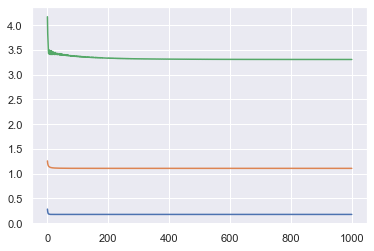

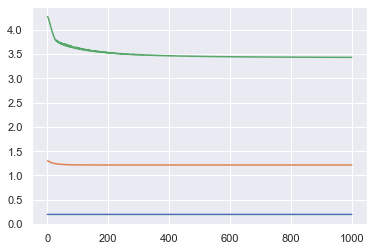

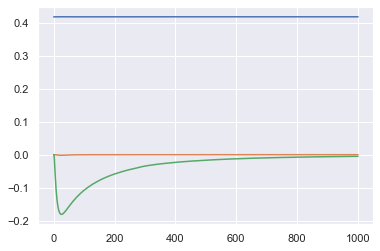

In [ ]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_d[i])
    
    plt.show()

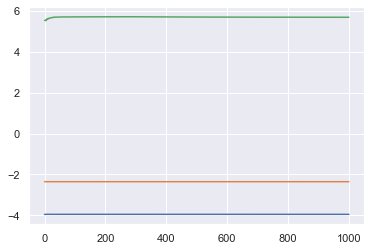

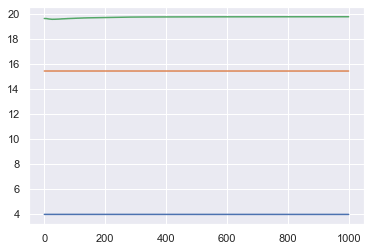

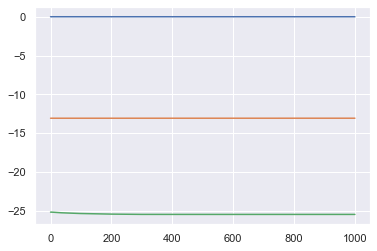

In [ ]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_w[i])
    
    plt.show()

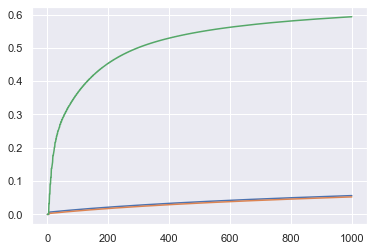

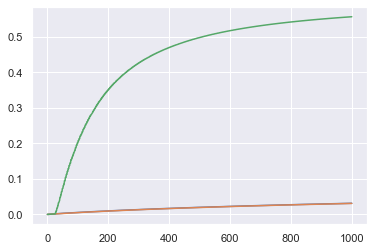

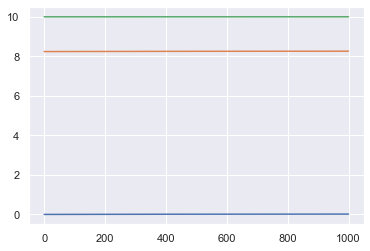

In [ ]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_j[i])
    
    plt.show()

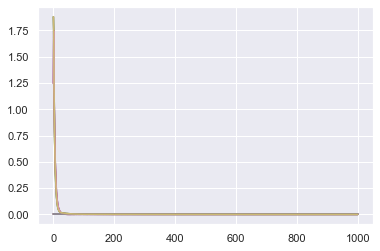

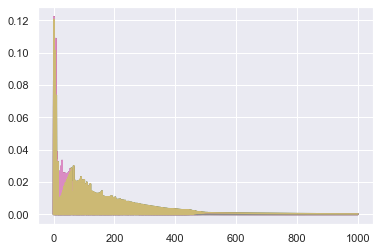

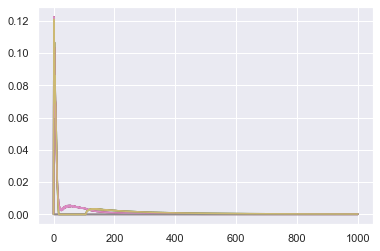

In [26]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(plot_penalty_residual[agent.id][i])
    
    plt.show()


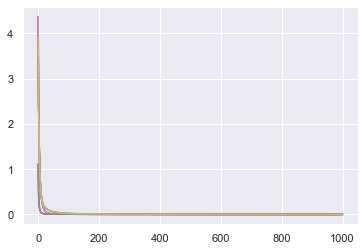

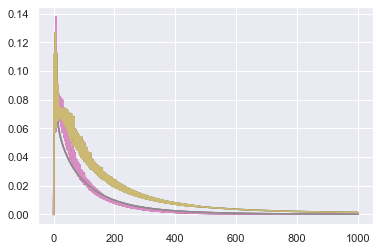

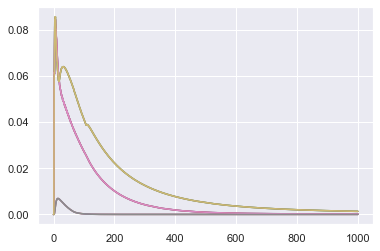

In [27]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(plot_balance[agent.id][i])
    
    plt.show()